## UHH-LT at SemEval-2020 Task 12: Fine-Tuning of Pre-Trained Transformer Networks for Offensive Language Detection

#### Step 1: Installation of requirements

In [ ]:
!pip3 install -r requirements.txt

In [1]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
torch.cuda.current_device()

0

In [2]:
import pandas as pd
import numpy as np
import pickle
import csv
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorboardX import SummaryWriter
from os import listdir
from os.path import isfile, join

In [3]:
# Use this code when on GPU
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=5


In [4]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [5]:
torch.cuda.empty_cache()

In [6]:
#Load dataset
import datasets as ds
#For Task A
dataset = ds.OffensEvalData2020A(path="datasets/OffensEval20", n_max=-1)
s_train, s_test = dataset.getData()

Counter({'NOT': 9460, 'OFF': 4640})


In [7]:
#Task A Labels
id2label = {0:'NOT', 1:'OFF'}
label2id = {'NOT':0, 'OFF':1}

In [8]:
dev_n = -1
X = []
for i, t in enumerate(s_train.texts):
    if i == dev_n:
        break
    X.append((t, s_train.labels[i]))
X_test = []
for i, t in enumerate(s_test.texts):
    X_test.append((t, s_test.ids[i]))

In [9]:
X_train = X
X_dev = X_test

In [10]:
import importlib
#importlib.reload(utils)
import utils
convert_examples_to_features = utils.convert_examples_to_features
importlib.reload(utils)

<module 'utils' from '/srv/home/8vijayak/FINAL_uhhlt-offenseval2020/utils.py'>

In [11]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from tensorboardX import SummaryWriter

from transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                                  AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer,
                                  T5Config, T5Tokenizer,
                                  XLMRobertaConfig, XLMRobertaForSequenceClassification, XLMRobertaTokenizer)

from transformers import AdamW, get_linear_schedule_with_warmup

from utils_classification import (convert_examples_to_features, output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

#### Step 2: Select the model by changing the index

In [12]:
#Only for the best performing model Albert
dict_model_names = {1: 'albert-base-v1',
                    2: 'albert-large-v1',
                    3: 'albert-xlarge-v1',
                    4: 'albert-xxlarge-v1', 
                    
                    5: 'albert-base-v2', 
                    6: 'albert-large-v2', 
                    7: 'albert-xlarge-v2', 
                    8: 'albert-xxlarge-v2'}

In [13]:
args = {
    'data_dir': 'data/',
    'model_type':  'albert',
    'model_name': str(dict_model_names[1]), #As per the required model, change the index
    #'task_name': 'offensiveA',
    'task_name': 'oe2020_A',
    'output_dir': 'oe2020-albert-A/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 4,
    'eval_batch_size': 4,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 6,
    'weight_decay': 0,
    'learning_rate': 5e-6,
    'adam_epsilon': 1e-9,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,


    'logging_steps': 0,
    'evaluate_during_training': True,
    'save_steps': 1000,
    'eval_all_checkpoints': True,
    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Offensive language classification task'
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Output dir: " + str(args['output_dir']))
print("Model Name: " + str(args['model_name']))
args['output_dir'] = args['output_dir']+args['task_name']+"/"+args['model_name']+"/"
print("Output Dir: " + str(args['output_dir']))

Output dir: oe2020-albert-A/
Model Name: albert-base-v1
Output Dir: oe2020-albert-A/oe2020_A/albert-base-v1/


In [14]:
device

device(type='cuda')

In [15]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    'albert': (AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer),
    't5': (T5Config, T5Tokenizer),
    'xlmroberta': (XLMRobertaConfig, XLMRobertaForSequenceClassification, XLMRobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

In [16]:
config = config_class.from_pretrained(args['model_name'], num_labels=2, finetuning_task=args['task_name']) #Task A
tokenizer = tokenizer_class.from_pretrained((args['model_name']))

In [17]:
task = args['task_name']
processor = processors[task](X_train, X_dev)
label_list = processor.get_labels()
num_labels = len(label_list)

In [18]:
#For Task A: ['NOT', 'OFF']
print("Number of labels is: " + str(num_labels))
print("The labels for Task A are: " + str(label_list))

Number of labels is: 2
The labels for Task A are: ['NOT', 'OFF']


# Training

#### Step 3: Load model and train them on the loaded dataset

In [ ]:
model = model_class.from_pretrained(args['model_name'], num_labels=num_labels)

In [ ]:
print(torch.cuda.current_device())

In [ ]:
%%capture
model.to(device)

In [ ]:
def load_and_cache_examples(task, tokenizer, evaluate=False):
    processor = processors[task](X_train, X_dev)
    output_mode = args['output_mode']
    
    mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = processor.get_labels()
        examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
            cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
            cls_token=tokenizer.cls_token,
            sep_token=tokenizer.sep_token,
            cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
            pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
            pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

                                        
from pprint import pprint
                                        
def train(train_dataset, model, tokenizer):
    tb_writer = SummaryWriter()
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args['warmup_steps'], num_training_steps=t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    epoch_i = 0
    max_metric = 0
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        epoch_i += 1
        print("Training Epoch %d" % epoch_i)
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:

                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()

                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results, _ = evaluate(model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

        # Save model checkpoint
        output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(epoch_i))
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        logger.info("Saving model checkpoint to %s", output_dir)


    return global_step, tr_loss / global_step

In [19]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import pearsonr

In [20]:
def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {
        "mcc": mcc,
        #These are uncommented in Seid's code
         "tp": tp,
         "tn": tn,
         "fp": fp,
         "fn": fn,
        "acc" : acc,
        "f1" : f1
    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, evaluate=True)
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    # print(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    results.update(result) 

    return results, wrong

In [ ]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer)
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

#### Step 4. Save the pre-trained check points under the respective folders

In [ ]:
#run this only for training
if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args['output_dir'])
    tokenizer.save_pretrained(args['output_dir'])
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

# Predict sentences

#### Step 5: Evaluate the pre-trained model on the test set

In [ ]:
def prepare_prediction(task, X_predict, tokenizer):
    processor = processors[task](X_predict, None)
    output_mode = args['output_mode']
    examples = processor.get_train_examples(None)
    features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
        cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
        cls_token=tokenizer.cls_token,
        sep_token=tokenizer.sep_token,
        cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
        pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
        pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
    
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [ ]:
def predict_sentences(sentences):
    X = [(s, 'OFF') for s in sentences]
    predict_dataset = prepare_prediction(task, X, tokenizer)
    eval_sampler = SequentialSampler(predict_dataset)
    eval_dataloader = DataLoader(predict_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])
    prefix = ""
    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(predict_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    
    sm = torch.nn.Softmax(dim=1)
    probabilities = sm(torch.from_numpy(preds)).numpy()
    # relevancy_scores = probabilities[:,1]

    return probabilities

In [ ]:
#run this for evaluation
test_sentences, test_ids = zip(*X_test)
fold_model_dirs = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
emsemble_preds = np.empty((len(test_sentences), len(fold_model_dirs)))
for i, fold_dir in enumerate(fold_model_dirs):
    print(fold_dir)
    model = model_class.from_pretrained(fold_dir)
    model.to(device)
    prob_scores = predict_sentences(test_sentences)
    predicted_labels = [a.argmax() for a in prob_scores]
    emsemble_preds[:, i] = predicted_labels

In [ ]:
#run this if the previous code is snippet is run. This saves the ensemble predictions to the file
pickle.dump(emsemble_preds, file=open(os.path.join(args['output_dir'], "testset_predictions.p"), "wb"))
emsemble_preds

In [ ]:
mean_preds = emsemble_preds.mean(axis=1)
mean_preds.tolist()

# Import all the Predictions and Majority Vote

Once all the model are available, run only this section to ensemble the models and generated the majority vote as mentioned in the paper. 

In [21]:
def get_eval_report2(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    acc = accuracy_score(labels, preds)
    
    # macro
    f1 = f1_score(labels, preds, average='macro')
    p = precision_score(labels, preds, average='macro')
    r = recall_score(labels, preds, average='macro')
    
    # not
    f1_0 = f1_score(labels, preds, average='binary', pos_label=0)
    p_0 = precision_score(labels, preds, average='binary', pos_label=0)
    r_0 = recall_score(labels, preds, average='binary', pos_label=0)
    
    # off
    f1_1 = f1_score(labels, preds, average='binary', pos_label=1)
    p_1 = precision_score(labels, preds, average='binary', pos_label=1)
    r_1 = recall_score(labels, preds, average='binary', pos_label=1)
    
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc" : acc,
        "f1" : f1,
        "precision" : p,
        "recall" : r,
        "p_not" : p_0,
        "r_not" : r_0,
        "f1_not" : f1_0,
        "p_off" : p_1,
        "r_off" : r_1,
        "f1_off" : f1_1
    }, get_mismatched(labels, preds)

#### Step 6: Load this pre-trained models and ensemble them

In [22]:
# Loading all files in the path with predictions
import os
path = 'oe2020-albert-A/oe2020_A/'
files = []
for r, d, f in os.walk(path):
    for file in f:
        if '.p' in file:
            files.append(os.path.join(r, file))
print(len(files))
for f in files:
    print(f)

8
oe2020-albert-A/oe2020_A/albert-xxlarge-v1/testset_predictions.p
oe2020-albert-A/oe2020_A/albert-xlarge-v2/testset_predictions.p
oe2020-albert-A/oe2020_A/albert-base-v2/testset_predictions.p
oe2020-albert-A/oe2020_A/albert-xlarge-v1/testset_predictions.p
oe2020-albert-A/oe2020_A/albert-large-v1/testset_predictions.p
oe2020-albert-A/oe2020_A/albert-large-v2/testset_predictions.p
oe2020-albert-A/oe2020_A/albert-xxlarge-v2/testset_predictions.p
oe2020-albert-A/oe2020_A/albert-base-v1/testset_predictions.p


In [23]:
test_sentences, test_ids = zip(*X_test)

In [24]:
len(test_sentences)

3887

# Only Albert

#### Step 7: Using the majority vote option, the predictions are computed

In [25]:
import pickle
preds = []
for f in files:
    if 'albert-xlarge-v2' in f:
        preds.append(pickle.load(open( f, "rb" )))
    if 'albert-xlarge-v1' in f:
        preds.append(pickle.load(open( f, "rb" )))
    if 'albert-xxlarge-v2' in f:
        preds.append(pickle.load(open( f, "rb" )))
    if 'albert-xxlarge-v1' in f:
        preds.append(pickle.load(open( f, "rb" )))
        
import numpy as np
merged_preds = np.concatenate(preds, axis = 1)
from collections import Counter
majority_preds = []
for i in range(merged_preds.shape[0]):
    majority_preds.append(Counter(merged_preds[i].astype(int)).most_common(1)[0][0])
mean_preds = merged_preds.mean(axis=1)
final_preds = majority_preds

In [26]:
lables = []
for i, t in enumerate(s_test.texts):
      lables.append(label2id[s_test.labels[i]])

#### Step 8: The Precision, Recall and F1 scores for labels {NOT, OFF} and overall Macro F1 and Accuracy are determined. 

In [27]:
#This code evaluated the predictions and calculates Precision, Recall and F1 scores for NOT and OFF labels.
# Also the Macro F1 and Accuracy for the entire ensemble
result, wrong = get_eval_report2(np.array(lables), final_preds)

In [28]:
print("NOT:" + "\t" +  "P: %s" %(str(round(result["p_not"]*100, 3))) + "\t" +  "R: %s" %(str(round(result["r_not"]*100, 2))) + "\t" +  "F1: %s" %(str(round(result["f1_not"]*100, 2))))
print("OFF:" + "\t" +  "P: %s" %(str(round(result["p_off"]*100, 2))) + "\t" +  "R: %s" %(str(round(result["r_off"]*100, 2))) + "\t" +  "F1: %s" %(str(round(result["f1_off"]*100, 2))))

NOT:	P: 98.299	R: 92.63	F1: 95.38
OFF:	P: 83.33	R: 95.83	F1: 89.15


In [29]:
print("F1: %s" %(str(round(result["f1"]*100, 2))) + "\t" + "ACC: %s" %(str(round(result["acc"]*100, 2))))

F1: 92.26	ACC: 93.52


# Confusion Matrix Plots

In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.array(lables), final_preds)
print(cm)

[[2600  207]
 [  45 1035]]


In [31]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.array(lables), final_preds)
print(cm)

[[2600  207]
 [  45 1035]]


In [32]:
import sklearn.metrics as sklm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.base import BaseEstimator, ClassifierMixin

class IdentityEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.is_fitted_ = True
        self.classes_ = [0, 1]

    def predict(self, X):
        return X
estim = IdentityEstimator()

def plot_conf_mat(true_labels, predicted_labels, label_names, plot_title):
    matplotlib.rcParams.update({'font.size': 20})
    disp = sklm.plot_confusion_matrix(estim, np.array(predicted_labels), true_labels, 
                                      cmap=plt.cm.Blues, values_format = '.5g',
                                      display_labels=label_names)
    disp.ax_.set_title(plot_title)
    plt.show()

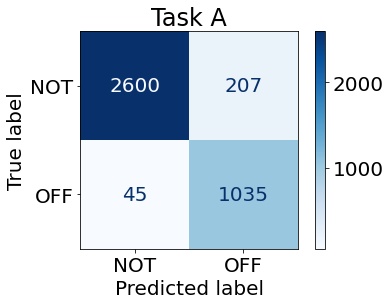

In [33]:
plot_conf_mat(np.array(lables), final_preds, ['NOT', 'OFF'], 'Task A')